In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR, get_net_currents, cross_correlation, min_max_scale
from nanonets.utils import create_weighted_undirected_graph, display_net_flow_graph
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"

In [4]:
AMPLITUDE_LIST  = [0.02]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9

topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

### Internal Dynamics

In [3]:
e_type      = 'constant'
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data        = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
print("data loaded")
states      = {amp : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
print("states loaded")
currents    = {amp : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6 for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
print("currents loaded")


data loaded
states loaded
currents loaded


### Charge Penetration

In [4]:
amp      = 0.02
t_points = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_vecs = {}
q_vecs   = {}
t_vecs   = {}
x_vecs   = {}
y_vecs   = {}

for freq in FREQ_LIST_MHZ:

    t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e9
    x       = data[amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:]*1000
    y       = data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:]*1e-6
    phi_vec = states[amp][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,N_ELECTRODES:].values
    q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE

    phi_vecs[freq]  = phi_vec.copy()
    q_vecs[freq]    = q_vec.copy()
    t_vecs[freq]    = t.copy()
    x_vecs[freq]    = x.copy()
    y_vecs[freq]    = y.copy()

In [ ]:
def analyze_lattice_with_moments(arr: np.ndarray):
    """
    Analyzes the full 2D lattice using a model-free moment-based approach on projected profiles.

    Calculates the "center of charge" (mean) and "charge spread" (RMS width)
    for the FULL distribution projected onto the horizontal (x) and vertical (y) axes.

    Args:
        arr (np.ndarray): A 9x9 NumPy array of the lattice state (charge or potential).

    Returns:
        Tuple[float, float, float, float]: A tuple containing:
            - mean_x (float): The center of charge along the x-axis.
            - width_x (float): The RMS spread of charge along the x-axis (Lateral Spread).
            - mean_y (float): The center of charge along the y-axis (Penetration Depth).
            - width_y (float): The RMS spread of charge along the y-axis (Longitudinal Spread).
    """
    ny, nx = arr.shape
    x_coords = np.arange(nx)
    y_coords = np.arange(ny)

    # Use absolute values as weights (magnitude of excitation)
    weights = np.abs(arr)
    total_weight = np.sum(weights)

    # Avoid division by zero if there's no charge
    if total_weight == 0:
        return np.nan, np.nan, np.nan, np.nan

    # --- 1. Project 2D Data to 1D Axes ---
    # Instead of taking a single slice, we SUM over the perpendicular axis.
    # This captures charge moving in the "wings," not just the center line.
    profile_x = np.sum(weights, axis=0)  # Sum columns to get X distribution
    profile_y = np.sum(weights, axis=1)  # Sum rows to get Y distribution

    # --- 2. Calculate Moments for X ---
    # Mean position X
    mean_x = np.sum(x_coords * profile_x) / total_weight
    
    # RMS width X
    var_x = np.sum(((x_coords - mean_x)**2) * profile_x) / total_weight
    width_x = np.sqrt(var_x)

    # --- 3. Calculate Moments for Y ---
    # Mean position Y
    mean_y = np.sum(y_coords * profile_y) / total_weight
    
    # RMS width Y
    var_y = np.sum(((y_coords - mean_y)**2) * profile_y) / total_weight
    width_y = np.sqrt(var_y)

    return mean_x, width_x, mean_y, width_y

N_samples   = 20
q_c_max     = []
q_c_zero    = []
phi_c_max   = []
phi_c_zero  = []
charge      = True

for freq in FREQ_LIST_MHZ:
    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
    q_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
    q_c_max.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
    phi_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
    phi_c_max.append(vals)

if charge:
    mean_x_max  = np.array([[q_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[q_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[q_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[q_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[q_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[q_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[q_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[q_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
else:
    mean_x_max  = np.array([[phi_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[phi_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[phi_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[phi_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[phi_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[phi_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[phi_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[phi_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

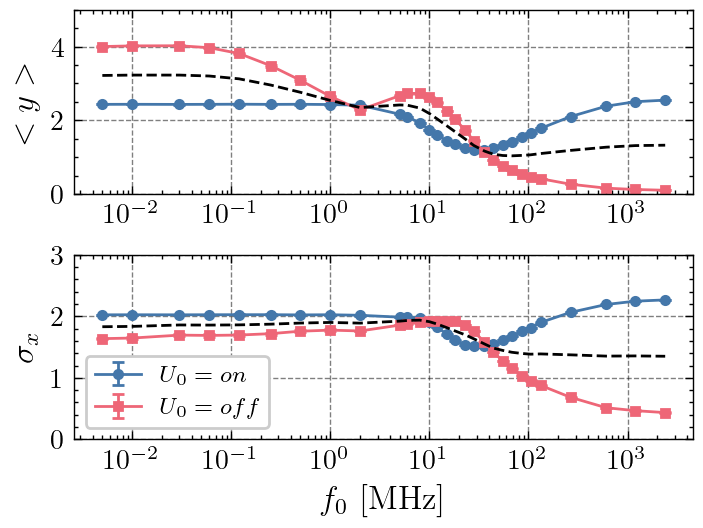

In [14]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot(2,1,1)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_max,axis=1), 1.95*np.std(mean_y_max,axis=1)/np.sqrt(N_samples), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_zero,axis=1), 1.95*np.std(mean_y_zero,axis=1)/np.sqrt(N_samples), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(mean_y_max,axis=1)+np.mean(mean_y_zero,axis=1))/2, '--', color='black', zorder=10)
# _ = ax.set_title(f"$U_0 = {amp*1000}$ mV")
_ = ax.set_ylabel("$<y>$", fontsize='large')
_ = ax.set_xscale('log')
if charge:
    _ = ax.set_ylim(0,5)
else:
    _ = ax.set_ylim(1,5)
ax = fig.add_subplot(2,1,2)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_max,axis=1), 1.95*np.std(width_x_max,axis=1)/np.sqrt(N_samples), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_zero,axis=1), 1.95*np.std(width_x_zero,axis=1)/np.sqrt(N_samples), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(width_x_max,axis=1)+np.mean(width_x_zero,axis=1))/2, '--', color='black', zorder=10)
_ = ax.set_xscale('log')
if charge:
    _ = ax.set_ylim(0,3)
else:
    _ = ax.set_ylim(1,3)
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$\sigma_x$", fontsize='large')
_ = ax.legend(fontsize='small', loc='lower left')

if charge:
    fig.savefig(f"plots/svg/charge_penetration.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_penetration.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_penetration.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_penetration.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_penetration.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_penetration.png", transparent=False)

### Anisotropy

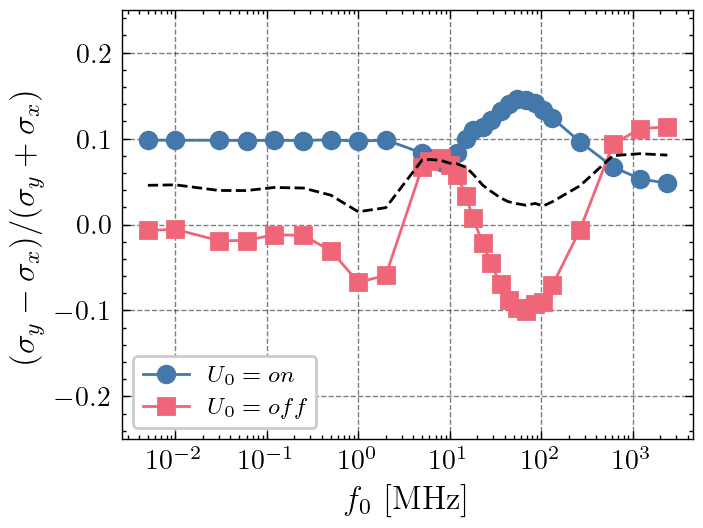

In [18]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1)),'-o', label='$U_0 = on$')
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)),'-s', label='$U_0 = off$')
ax.plot(FREQ_LIST_MHZ, ((np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1))+
                        (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)))/2, '--', color='black', zorder=10)
# _ = ax.set_title(f"$U_0 = {amp*1000}$ mV")
_ = ax.set_ylabel("$(\sigma_y-\sigma_x)/(\sigma_y+\sigma_x)$", fontsize='large')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_ylim(-0.25,0.25)
_ = ax.legend(fontsize='small', loc='lower left')
if charge:
    fig.savefig(f"plots/svg/charge_anisotropy.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_anisotropy.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_anisotropy.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_anisotropy.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_anisotropy.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_anisotropy.png", transparent=False)

### Current Percolation

In [71]:
rms_gs      = {}
rms_flow    = {}
for amp in AMPLITUDE_LIST:
    df_net_00   = get_net_currents(currents[amp][0.005].copy())
    rms_00      = np.sqrt((df_net_00**2).sum())
    rms_gs2     = []
    rms_flow2   = []
    for freq in FREQ_LIST_MHZ:
        df_net  = get_net_currents(currents[amp][freq].copy())
        rms     = np.sqrt((df_net**2).sum())
        rms_q   = rms/rms_00
        print(rms_q.mean())
        # G       = create_weighted_undirected_graph(rms)
        G       = create_weighted_undirected_graph(rms_q)
        rms_gs2.append(G)
        rms_flow2.append(nx.maximum_flow_value(G, _s=0, _t=7, capacity='weight'))
    rms_gs[amp]   = rms_gs2
    rms_flow[amp] = rms_flow2

1.0
1.0023056141146922
1.0094264031501607
1.019996095075947
1.0451013646184848
1.0519269024263835
1.0507823483643972
1.0492760606670155
1.041524639304239
0.987341592291232
0.967802114423223
0.8988509020685134
0.8193445406297618
0.7381866902944549
0.623866217568868
0.5358775224324382
0.4275935473214258
0.36073184399589553
0.2914846797918733
0.2505751454078532
0.21343701818418448
0.18632865433788112
0.1616755089012767
0.14432937050194794
0.12708495217407237
0.09252820079079684
0.06606649211023283
0.054406265186135366
0.048373013963749066


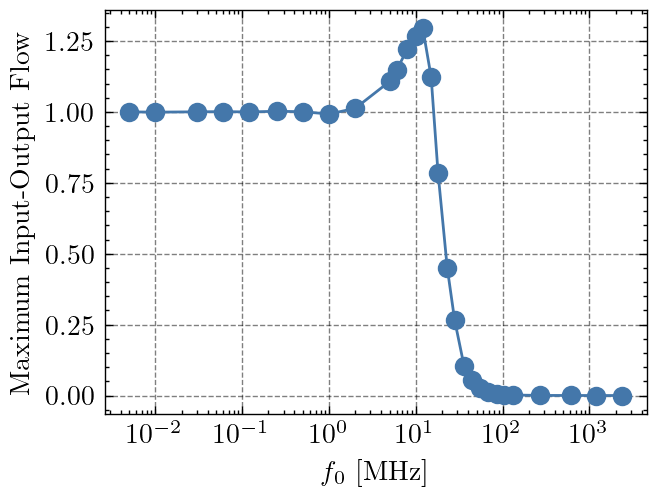

In [75]:
amp     = 0.02
fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, rms_flow[amp], '-o')
ax.set_xscale("log")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("Maximum Input-Output Flow")
fig.savefig(f"plots/svg/max_flow_input_output.svg", transparent=True)
fig.savefig(f"plots/pdf/max_flow_input_output.pdf", transparent=False)
fig.savefig(f"plots/png/max_flow_input_output.png", transparent=False)

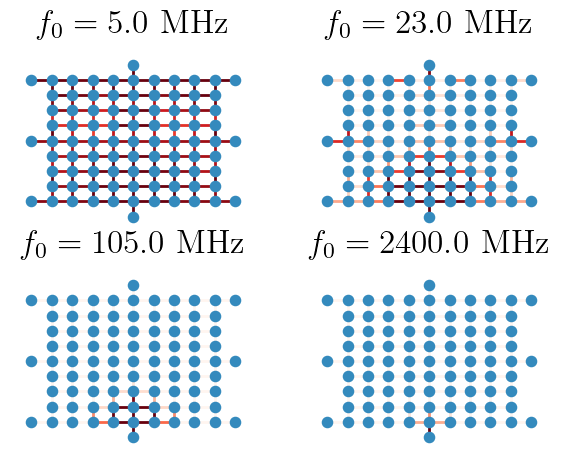

In [92]:
amp     = 0.02
freqs   = [5.0,23.0,105.,2400.0]
fig     = plt.figure(dpi=200)
for i, freq in enumerate(freqs):
    ax  = fig.add_subplot(2,2,i+1)
    idx = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
    ax  = display_net_flow_graph(rms_gs[amp][idx], pos=pos, log_sacle=False, font_size=None, ax=ax, vmin=0.1, vmax=1, node_size=10)
    _   = ax.set_title(f"$f_0 = {freq}$ MHz")
fig.savefig(f"plots/svg/net_flow_rms.svg", transparent=True)
fig.savefig(f"plots/pdf/net_flow_rms.pdf", transparent=False)
fig.savefig(f"plots/png/net_flow_rms.png", transparent=False)

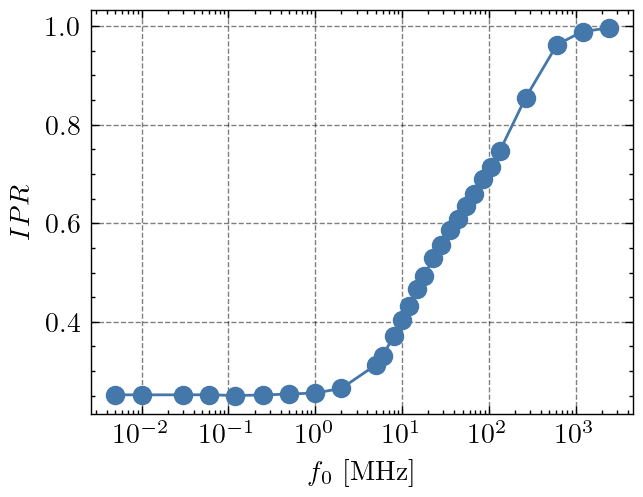

In [84]:
ipr = []
for freq in FREQ_LIST_MHZ:
    df_net  = get_net_currents(currents[amp][freq].copy())
    rms     = np.sqrt(np.sum(df_net.values**2,axis=0))
    num     = np.sum(rms**4)
    denom   = np.sum(rms**2)**2
    ipr.append(num/denom)

fig, ax = plt.subplots(dpi=200)
ax.plot(FREQ_LIST_MHZ, ipr, '-o')
ax.set_xscale("log")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$IPR$")
fig.savefig(f"plots/svg/IPR_internal_currents.svg", transparent=True)
fig.savefig(f"plots/pdf/IPR_internal_currents.pdf", transparent=False)
fig.savefig(f"plots/png/IPR_internal_currents.png", transparent=False)

---

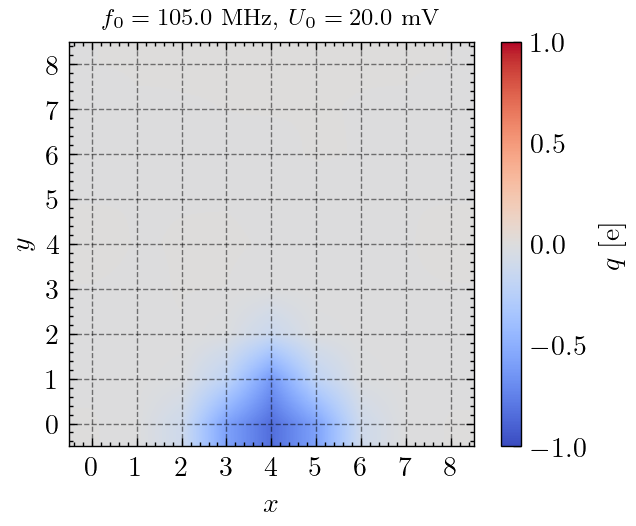

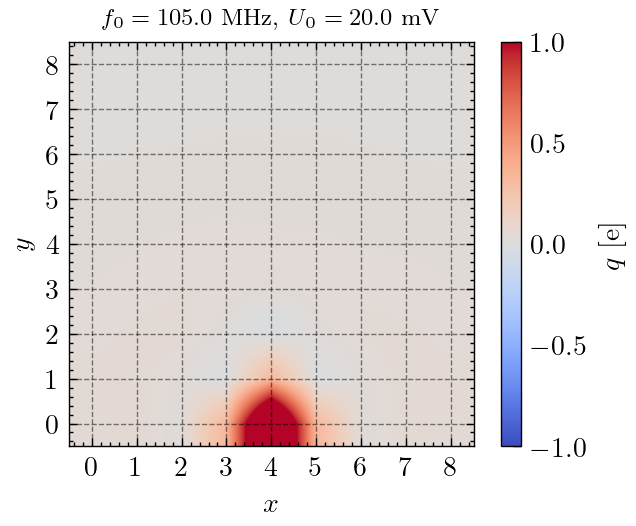

In [13]:
freq = 105.

arr = np.mean([q_vecs[freq][i*SAMPLE_P_PERIOD,:] for i in range(N_samples)],axis=0).reshape(9,9)
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear')
_   = ax.set_xlabel("$x$")
_   = ax.set_ylabel("$y$")
_   = ax.set_xticks(np.arange(9))
_   = ax.set_yticks(np.arange(9))
ax.invert_yaxis()
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.colorbar(im, ax=ax, label='$q$ [e]', orientation='vertical')
fig.savefig(f"plots/svg/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/max_charge_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

arr = np.mean([q_vecs[freq][i*SAMPLE_P_PERIOD+int(0.25*SAMPLE_P_PERIOD),:] for i in range(N_samples)],axis=0).reshape(9,9)
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear')
_   = ax.set_xlabel("$x$")
_   = ax.set_ylabel("$y$")
_   = ax.set_xticks(np.arange(9))
_   = ax.set_yticks(np.arange(9))
ax.invert_yaxis()
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
fig.colorbar(im, ax=ax, label='$q$ [e]', orientation='vertical')
fig.savefig(f"plots/svg/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/center_charge_landscape_{freq:.3f}_{amp:.3f}.png", transparent=False)

### Time Constants

In [14]:
taus = np.zeros(shape=(len(FREQ_LIST_MHZ),int(N_NP*N_NP)))

for j, freq in enumerate(FREQ_LIST_MHZ):
    x_vals  = x_vecs[freq].copy()
    for n in range(N_NP*N_NP):
        y_vals      = q_vecs[freq][:,n]
        c_vals      = correlate(y_vals, x_vals, mode='same')
        midpoint    = len(c_vals) // 2
        i_val       = np.argmax(c_vals) - midpoint
        t_val       = i_val * dts[freq]
        T           = 1 / (freq * 1e6)
        # t_val_phys = ((t_val + 0.5*T) % T) - 0.5*T
        t_val_phys  = t_val % T
        taus[j,n]   = t_val_phys / T
taus_df = pd.DataFrame([taus[i,:] for i in range(len(FREQ_LIST_MHZ))], index=FREQ_LIST_MHZ).T.melt(var_name='freq',value_name='tau')
taus_df.to_csv(f"data/taus_df_{amp:.3f}.csv")

/tmp/ipykernel_30860/965283697.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax  = sns.violinplot(data=taus_df, x='freq', y='tau', cut=0, ax=ax, scale='width', color=BLUE_COLOR, inner='point')


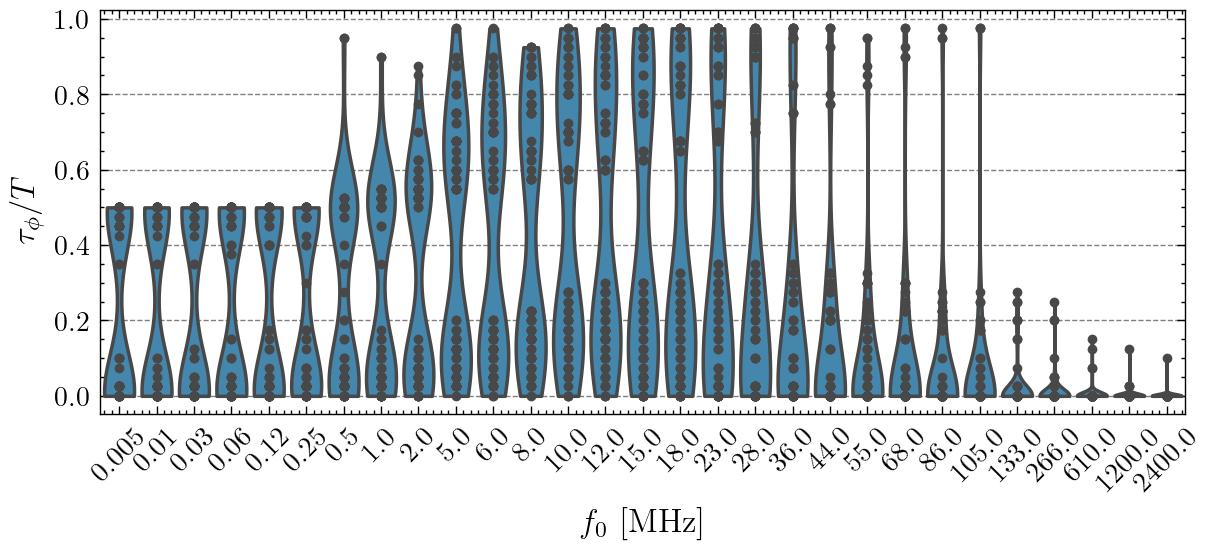

In [15]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=taus_df, x='freq', y='tau', cut=0, ax=ax, scale='width', color=BLUE_COLOR, inner='point')
_   = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_ylabel("$\\tau_\phi / T$", fontsize='large')
_   = plt.xticks(rotation=45)
fig.savefig(f"plots/svg/tau_vs_freq_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/tau_vs_freq_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/tau_vs_freq_{amp:.3f}.png", transparent=False)

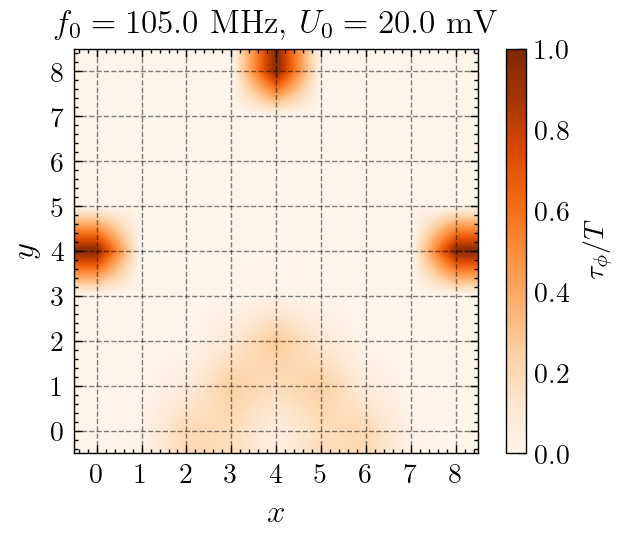

In [17]:
freq = 105.0
idx  = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
arr  = taus[idx,:].reshape(N_NP,N_NP)
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
im  = ax.imshow(arr, cmap='Oranges', vmin=0, vmax=1, interpolation='bilinear')
_   = ax.set_xticks(np.arange(N_NP))
_   = ax.set_yticks(np.arange(N_NP))
_   = fig.colorbar(im, ax=ax, label='$\\tau_\phi / T$', orientation='vertical')
ax.invert_yaxis()
ax.set_xlabel("$x$", fontsize='large')
ax.set_ylabel("$y$", fontsize='large')
ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV")
fig.savefig(f"plots/svg/tau_dist_{freq:.3f}_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/tau_dist_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/tau_dist_{freq:.3f}_{amp:.3f}.png", transparent=False)

### New Power Measurement

In [20]:
power_dfs = {}
for freq in FREQ_LIST_MHZ:
    phis        = phi_vecs[freq].copy()
    curr        = get_net_currents(currents[0.02][freq].copy())
    power_data  = {}
    for col in curr.columns:
        c_vals  = curr[col].copy()
        i,j     = eval(col)
        i       -= N_ELECTRODES
        j       -= N_ELECTRODES

        if i == -N_ELECTRODES:
            x = x_vecs[freq].copy()
        elif (i < 0) and (i > -N_ELECTRODES):
            x = np.repeat(0, curr.shape[0])
        else:
            x = phi_vecs[freq][:,i]

        if j == -N_ELECTRODES:
            y = x_vecs[freq].copy()
        elif i < 0:
            y = np.repeat(0, curr.shape[0])
        else:
            y = phi_vecs[freq][:,j]
        
        p_val = (x-y)*c_vals
        power_data[col] = p_val.copy()
    power_dfs[freq] = pd.DataFrame(power_data)

In [22]:
amp         = 0.02
conductance = []
work_per_c  = []
for key, df in power_dfs.items():
    t = time[freq][:-1][:SAMPLE_P_PERIOD+1]
    p = df.sum(axis=1).values[:SAMPLE_P_PERIOD+1]
    w = 2*np.trapezoid(p, t) / (t[-1]-t[0])
    work_per_c.append(w)
    conductance.append(w/(amp**2))

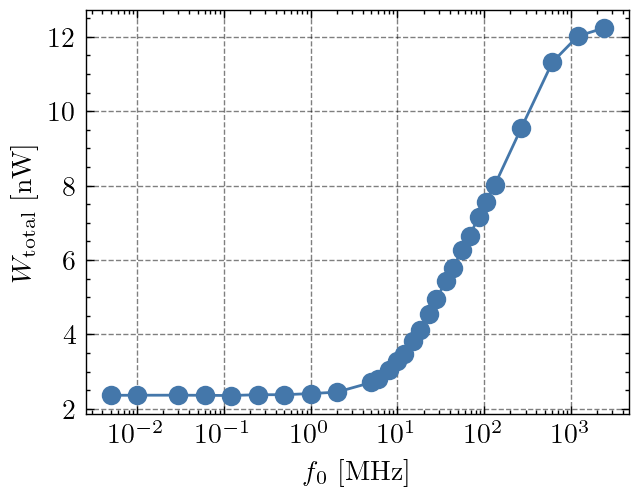

In [25]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, np.array(work_per_c)*1e-3, '-o')
ax.set_xscale('log')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$W_{\\text{total}}$ [nW]")
fig.savefig(f"plots/svg/internal/W_total_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/W_total_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/W_total_{amp:.3f}.png", transparent=False)

### Animation

In [ ]:
# def animate_potential_landscape(potential_data_list, t_vector: np.ndarray,
#                                 title_prefix: str = "Potential Landscape",
#                                 output_filename: str = "potential_animation.mp4"):
#     """
#     Creates and saves an animation of the 9x9 potential landscape over time.

#     Args:
#         potential_data_list (List[np.ndarray]): A list of 2D numpy arrays, where each
#                                              array has shape (9, 9) and represents
#                                              the node potentials at a single time step.
#         t_vector (np.ndarray): 1D numpy array of time values corresponding to the frames.
#         title_prefix (str): A string to prepend to the animation title (e.g., "Active Regime").
#         output_filename (str): The filename to save the animation (e.g., 'animation.mp4' or 'animation.gif').
#                                Requires a writer like ffmpeg or imagemagick.
#     """
    
#     with plt.style.context(["science","bright","grid"]):

#         # --- Convert list of 2D arrays to a single 3D numpy array for easier handling ---
#         try:
#             potential_data_TXY = np.array(potential_data_list)
#         except Exception as e:
#             raise TypeError(f"Could not convert the input list to a NumPy array. Please ensure it's a list of 2D arrays. Error: {e}")

#         # Basic validation
#         if potential_data_TXY.ndim != 3 or potential_data_TXY.shape[1:] != (N_NP, N_NP):
#             raise ValueError("Input data must resolve to a 3D array of shape (num_timesteps, 9, 9).")

#         num_timesteps = potential_data_TXY.shape[0]

#         # --- Setup the plot ---
#         fig, ax = plt.subplots(layout='tight')

#         # Determine a fixed color scale based on the global min/max of the entire dataset.
#         # This is CRITICAL to prevent the color bar from flickering.
#         vmin = -np.max(np.abs(potential_data_TXY))
#         vmax = np.max(np.abs(potential_data_TXY))

#         # Display the first frame (t=0)
#         # We use origin='lower' to match your coordinate system (y=0 at the bottom).
#         im = ax.imshow(potential_data_TXY[0, :, :], vmin=vmin, vmax=vmax,
#                         cmap='coolwarm', origin='lower', interpolation='bicubic')

#         ax.set_xlabel("$x$")
#         ax.set_ylabel("$y$")
#         ax.set_xticks(np.arange(N_NP))
#         ax.set_yticks(np.arange(N_NP))

#         cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#         cbar.set_label("$\phi$ [mV]")

#         time_text = ax.set_title("")

#         # --- Animation update function ---
#         def update(frame_index):
#             data_slice = potential_data_TXY[frame_index, :, :]
#             im.set_array(data_slice)
#             current_time = t_vector[frame_index]
#             time_text.set_text(f'Time: {1000*current_time:.1f} ms')
#             return [im, time_text]

#         # --- Create and save the animation ---
#         print("Creating animation... This may take a few moments.")

#         if len(t_vector) > 1:
#             dt = (t_vector[1] - t_vector[0]) * 1000  # interval in ms
#         else:
#             dt = 50  # default to 20 fps

#         ani = FuncAnimation(fig, update, frames=num_timesteps,
#                             interval=dt, blit=True, repeat=True)

#         try:
#             ani.save(output_filename, writer='ffmpeg', fps=15, dpi=150)
#             print(f"Animation successfully saved to '{output_filename}'")
#         except Exception as e:
#             print(f"Error saving animation: {e}")
#             print("Please ensure you have a writer like 'ffmpeg' installed and accessible in your system's PATH.")
            
#         plt.close(fig)

In [ ]:
# freq    = 18.0
# amp     = 0.02
# n_p     = 8
# f_name  = f"pot_landscape_{freq}_{amp}.gif"
# y       = states[amp][freq].iloc[:SAMPLE_P_PERIOD*n_p,N_ELECTRODES:].values*1000

# y_t = [np.array(y_t).reshape(9,9) for y_t in y.tolist()]
# t   = time[freq][:SAMPLE_P_PERIOD*n_p]*1e6

# animate_potential_landscape(y_t, t, output_filename=f_name)

MovieWriter ffmpeg unavailable; using Pillow instead.


Creating animation... This may take a few moments.
Animation successfully saved to 'pot_landscape_18.0_0.02.gif'


In [ ]:
# def get_2d_spatial_properties(arr: np.ndarray):
#     """
#     Calculates 2D spatial autocorrelation, correlation lengths, and anisotropy.

#     This function now returns the correlation map, the correlation lengths in x and y,
#     and a normalized anisotropy index.

#     Args:
#         arr (np.ndarray): A 2D NumPy array representing the lattice states.

#     Returns:
#         Tuple[np.ndarray, float, float, float]: A tuple containing:
#             - a_c (np.ndarray): The normalized 2D autocorrelation map.
#             - Lx (float): The correlation length along the x-axis.
#             - Ly (float): The correlation length along the y-axis.
#             - anisotropy (float): The normalized anisotropy index, ranging from -1 to 1.
#     """
#     if arr.std() == 0:
#         ny, nx = arr.shape
#         return np.ones_like(arr), float(nx), float(ny), 0.0

#     arr = arr - np.mean(arr)
#     a_c = correlate2d(arr, arr, mode='same', boundary='fill', fillvalue=0)
#     a_c /= np.max(a_c)

#     ny, nx = a_c.shape
#     cy, cx = ny // 2, nx // 2

#     prof_x = a_c[cy, :]
#     prof_y = a_c[:, cx]
#     lags_x = np.arange(nx) - cx
#     lags_y = np.arange(ny) - cy

#     def fit_correlation_length(profile: np.ndarray, lags: np.ndarray) -> float:
#         mid         = len(lags) // 2
#         lags_right  = lags[mid:]
#         prof_right  = np.maximum(profile[mid:], 1e-9)
#         def exp_decay(r, xi):
#             return np.exp(-r / xi)
#         params, _ = curve_fit(exp_decay, lags_right, prof_right, p0=[1.0])
#         return params[0]

#     Lx = fit_correlation_length(prof_x, lags_x)
#     Ly = fit_correlation_length(prof_y, lags_y)

#     # **Calculate anisotropy using your formula**
#     # Added a check to prevent division by zero for a noise-only case
#     denominator = Lx + Ly
#     if denominator > 0:
#         anisotropy = np.abs(Lx - Ly) / denominator
#     else:
#         anisotropy = 0.0

#     return a_c, Lx, Ly, anisotropy

# def analyze_source_driven_lattice(arr: np.ndarray):
#     """
#     Analyzes a lattice driven by a source at the center of the first row.

#     This function measures the horizontal spread and vertical penetration depth
#     by fitting Gaussian and Exponential models to direct profiles from the source.

#     Args:
#         arr (np.ndarray): A 9x9 NumPy array of the lattice state.

#     Returns:
#         Tuple[float, float]: A tuple containing:
#             - spread_width (float): The standard deviation (sigma) of the Gaussian
#                                     fit along the x-axis at the source.
#             - penetration_depth (float): The decay constant (lambda) of the
#                                          exponential fit along the y-axis.
#     """
#     ny, nx = arr.shape
#     center_x = nx // 2

#     # 1. Extract the profiles from the known source location (y=0, x=center)
#     horizontal_profile = arr[0, :]
#     vertical_profile = arr[:, center_x]
    
#     x_coords = np.arange(nx)
#     y_coords = np.arange(ny)

#     # 2. Define the physical models for fitting
#     def gaussian(x, amplitude, mean, sigma, offset):
#         return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2)) + offset

#     def exponential_decay(y, amplitude, decay_lambda, offset):
#         # Ensure lambda is positive to represent decay
#         return amplitude * np.exp(-y / abs(decay_lambda)) + offset

#     try:
#         # 3. Fit the horizontal profile to find the spread width
#         h_offset_guess  = (horizontal_profile[0] + horizontal_profile[-1]) / 2.0
#         h_amp_guess     = np.max(horizontal_profile) - h_offset_guess
#         p0_h            = [h_amp_guess, center_x, 1.0, h_offset_guess]
#         params_h, _     = curve_fit(gaussian, x_coords, horizontal_profile, p0=p0_h)
#         spread_width    = abs(params_h[2]) # sigma_x

#         # 4. Fit the vertical profile to find the penetration depth
#         v_offset_guess      = vertical_profile[-1]
#         v_amp_guess         = vertical_profile[0] - v_offset_guess
#         p0_v                = [v_amp_guess, 1.0, v_offset_guess]
#         params_v, _         = curve_fit(exponential_decay, y_coords, vertical_profile, p0=p0_v)
#         penetration_depth   = abs(params_v[1]) # lambda_y

#     except (RuntimeError, ValueError):
#         # If fitting fails for any reason, return NaN or a default value
#         return np.nan, np.nan

#     return spread_width, penetration_depth

# freq = 266.0
# idx  = np.argwhere(np.array(FREQ_LIST_MHZ)==freq)[0][0]
# fig = plt.figure(dpi=200)
# ax  = fig.add_subplot()
# im  = ax.imshow(phi_c_m_max[idx], cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear', extent=[-4, 4, -4, 4])
# _   = ax.set_xticks(np.arange(-4,5))
# _   = ax.set_yticks(np.arange(-4,5))
# _   = fig.colorbar(im, ax=ax, label='$C(\Delta x,\Delta y)$', orientation='vertical')
# ax.set_xlabel("$\Delta x$")
# ax.set_ylabel("$\Delta y$")
# ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
# fig.savefig(f"plots/svg/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/c_maps/ac_map_at_max_{freq:.3f}_{amp:.3f}.png", transparent=False)

# fig = plt.figure(dpi=200)
# ax  = fig.add_subplot()
# im  = ax.imshow(phi_c_m_zero[idx], cmap='coolwarm', vmin=-1, vmax=1, interpolation='bilinear', extent=[-4, 4, -4, 4])
# _   = ax.set_xticks(np.arange(-4,5))
# _   = ax.set_yticks(np.arange(-4,5))
# _   = fig.colorbar(im, ax=ax, label='$C(\Delta x,\Delta y)$', orientation='vertical')
# ax.set_xlabel("$\Delta x$")
# ax.set_ylabel("$\Delta y$")
# ax.set_title(f"$f_0 = {freq}$ MHz, $U_0 = {amp*1000}$ mV", fontsize='small')
# fig.savefig(f"plots/svg/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/c_maps/ac_map_at_zero_{freq:.3f}_{amp:.3f}.png", transparent=False)